In [6]:
# --- SETUP ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings('ignore')


# Cargar archivo .env
# Ruta relativa desde el notebook hasta el .env
dotenv_path = '../generadores/.env'  #

# Cargar el archivo .env desde la ruta especificada
load_dotenv(dotenv_path=dotenv_path)

# Leer variables de entorno
username = os.getenv("USUARIO_DB")
password = os.getenv("CLAVE_BD")

# Validar que se cargaron bien
print("Usuario:", username)
print("Contrase√±a cargada:", bool(password))  # No imprime la clave, pero verifica si existe

if not username or not password:
    raise ValueError("Las variables de entorno USUARIO_DB o CLAVE_BD no est√°n definidas")

# Cadena de conexi√≥n
conn_str = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=upgradeserver-vf.database.windows.net;'
    'DATABASE=Banco;'
    f'UID={username};'
    f'PWD={password};'
    'Connection Timeout=30;'
)

# Conexi√≥n
conn = pyodbc.connect(conn_str)



Usuario: vanesa
Contrase√±a cargada: True


In [7]:
usuarios = pd.read_sql_query("SELECT * FROM usuarios", conn)
creditos = pd.read_sql_query("SELECT * FROM creditos", conn)
activos_financieros = pd.read_sql_query("SELECT usuario_id, tipo_activo, monto FROM activos_financieros", conn)
monedas_digitales = pd.read_sql_query("SELECT * FROM monedas_digitales", conn)
cuentas_bancarias = pd.read_sql_query("SELECT * FROM cuentas_bancarias", conn)

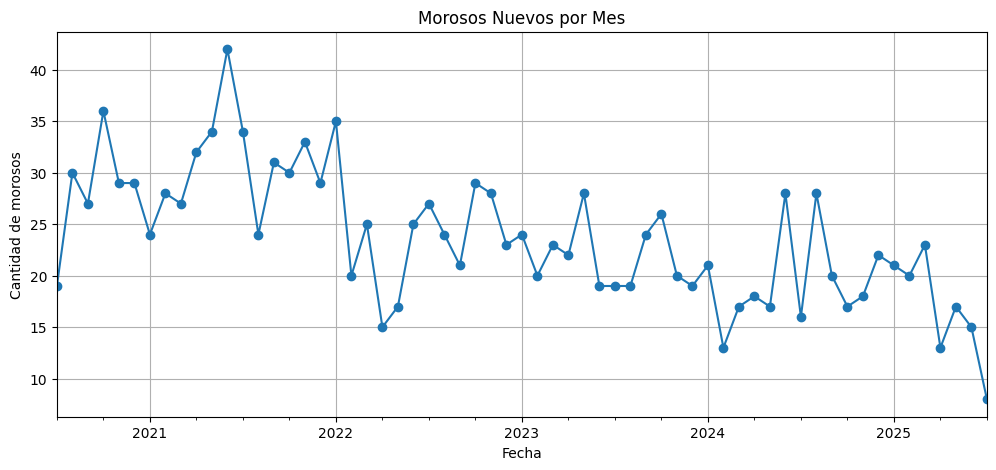


üìâ Predicci√≥n de morosos nuevos para los pr√≥ximos 6 meses:
       fecha  pred
0 2025-07-31  16.0
1 2025-08-31  16.0
2 2025-09-30  16.0
3 2025-10-31  15.0
4 2025-11-30  15.0
5 2025-12-31  15.0


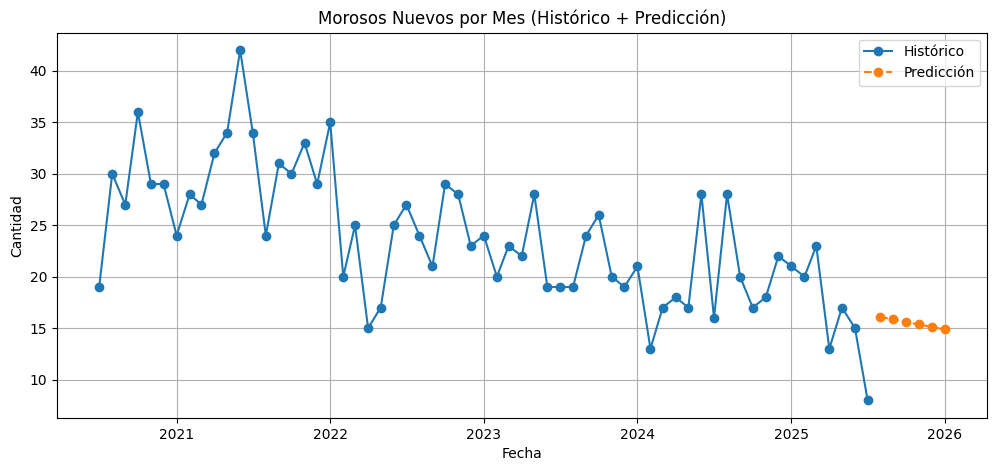

In [16]:
# --- PREDICCI√ìN DE MOROSOS NUEVOS POR MES ---

# Asegurarse de que la fecha est√© bien formateada
creditos['fecha_inicio'] = pd.to_datetime(creditos['fecha_inicio'], errors='coerce')

# Tomar el primer cr√©dito de cada usuario
primer_credito_morosidad = creditos.sort_values('fecha_inicio').drop_duplicates('usuario_id')

# Unir con la tabla de usuarios usando usuario_id
primer_credito_morosidad = primer_credito_morosidad.merge(
    usuarios[['id', 'es_moroso']],
    left_on='usuario_id',
    right_on='id',
    how='left'
)

# Agrupar morosos nuevos por mes
morosos_por_mes = (
    primer_credito_morosidad[primer_credito_morosidad['es_moroso'] == 1]
    .groupby(primer_credito_morosidad['fecha_inicio'].dt.to_period('M'))
    .size()
    .to_timestamp()
)

# Visualizaci√≥n hist√≥rica
morosos_por_mes.plot(marker='o', figsize=(12, 5), title='Morosos Nuevos por Mes')
plt.grid(True)
plt.ylabel("Cantidad de morosos")
plt.xlabel("Fecha")
plt.show()

# Preparar datos para regresi√≥n
df_morosos = morosos_por_mes.reset_index()
df_morosos.columns = ['fecha', 'morosos']
df_morosos['mes_num'] = np.arange(len(df_morosos))

# Modelo de regresi√≥n lineal
modelo_morosos = LinearRegression()
modelo_morosos.fit(df_morosos[['mes_num']], df_morosos['morosos'])

# Predicci√≥n para los pr√≥ximos 6 meses
futuro_morosos = pd.DataFrame({'mes_num': np.arange(len(df_morosos), len(df_morosos) + 6)})
futuro_morosos['pred'] = modelo_morosos.predict(futuro_morosos[['mes_num']])
futuro_morosos['fecha'] = pd.date_range(df_morosos['fecha'].max() + MonthEnd(1), periods=6, freq='M')

# Mostrar predicci√≥n
print("\nüìâ Predicci√≥n de morosos nuevos para los pr√≥ximos 6 meses:")
print(futuro_morosos[['fecha', 'pred']].round(0))

# Visualizaci√≥n combinada
plt.figure(figsize=(12, 5))
plt.plot(df_morosos['fecha'], df_morosos['morosos'], label='Hist√≥rico', marker='o')
plt.plot(futuro_morosos['fecha'], futuro_morosos['pred'], label='Predicci√≥n', marker='o', linestyle='--')
plt.title("Morosos Nuevos por Mes (Hist√≥rico + Predicci√≥n)")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()


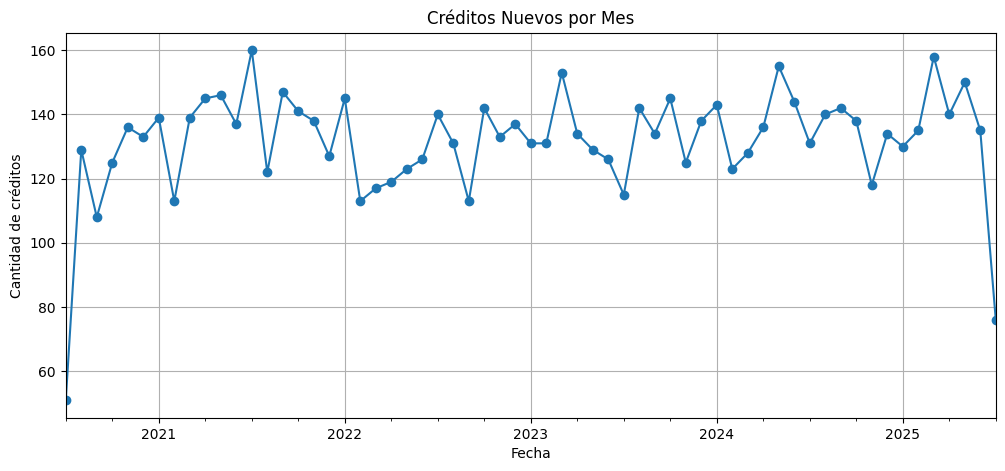


üìà Predicci√≥n de nuevos cr√©ditos para los pr√≥ximos 6 meses:
       fecha  pred_creditos
0 2025-07-31          137.0
1 2025-08-31          137.0
2 2025-09-30          137.0
3 2025-10-31          137.0
4 2025-11-30          138.0
5 2025-12-31          138.0


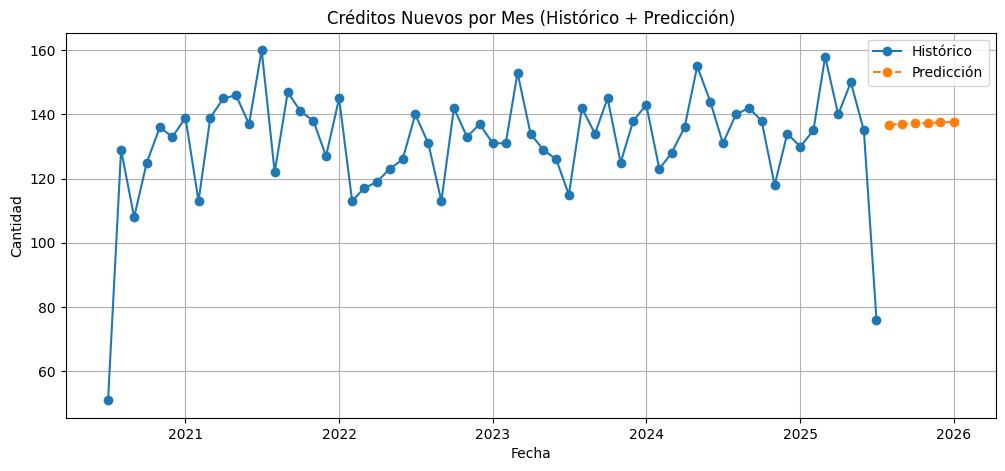

In [11]:
# --- PREDICCI√ìN A 6 MESES: NUEVOS CR√âDITOS ---
from sklearn.linear_model import LinearRegression
# Crear copia temporal para no modificar el DataFrame original
creditos_copia = creditos.copy()
creditos_copia['fecha_inicio'] = pd.to_datetime(creditos_copia['fecha_inicio'], errors='coerce')

# Agrupar por mes
creditos_por_mes = (
    creditos_copia
    .groupby(creditos_copia['fecha_inicio'].dt.to_period('M'))
    .size()
    .to_timestamp()
)

# Visualizaci√≥n hist√≥rica
creditos_por_mes.plot(marker='o', figsize=(12, 5), title='Cr√©ditos Nuevos por Mes')
plt.grid(True)
plt.ylabel("Cantidad de cr√©ditos")
plt.xlabel("Fecha")
plt.show()

# Crear variables para regresi√≥n
df_creditos = creditos_por_mes.reset_index()
df_creditos.columns = ['fecha', 'nuevos_creditos']
df_creditos['mes_num'] = np.arange(len(df_creditos))

# Entrenar modelo lineal
modelo_creditos = LinearRegression()
modelo_creditos.fit(df_creditos[['mes_num']], df_creditos['nuevos_creditos'])

# Predecir los pr√≥ximos 6 meses
futuro_creditos = pd.DataFrame({'mes_num': np.arange(len(df_creditos), len(df_creditos) + 6)})
futuro_creditos['pred_creditos'] = modelo_creditos.predict(futuro_creditos[['mes_num']])
futuro_creditos['fecha'] = pd.date_range(df_creditos['fecha'].max() + MonthEnd(1), periods=6, freq='M')

# Mostrar predicci√≥n
print("\nüìà Predicci√≥n de nuevos cr√©ditos para los pr√≥ximos 6 meses:")
print(futuro_creditos[['fecha', 'pred_creditos']].round(0))

# Visualizaci√≥n combinada
plt.figure(figsize=(12, 5))
plt.plot(df_creditos['fecha'], df_creditos['nuevos_creditos'], label='Hist√≥rico', marker='o')
plt.plot(futuro_creditos['fecha'], futuro_creditos['pred_creditos'], label='Predicci√≥n', marker='o', linestyle='--')
plt.title("Cr√©ditos Nuevos por Mes (Hist√≥rico + Predicci√≥n)")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()

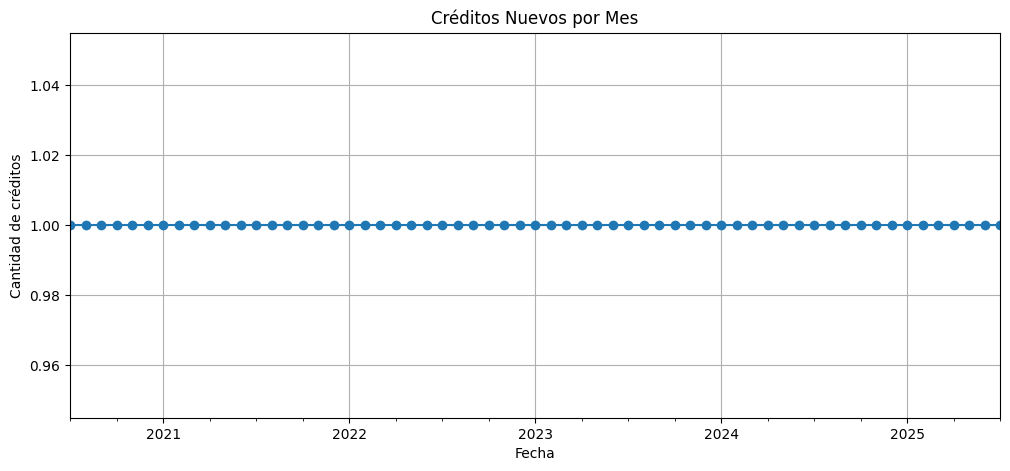


Predicci√≥n de nuevos cr√©ditos para los pr√≥ximos 6 meses:
       fecha  pred_creditos
0 2025-07-31            1.0
1 2025-08-31            1.0
2 2025-09-30            1.0
3 2025-10-31            1.0
4 2025-11-30            1.0
5 2025-12-31            1.0


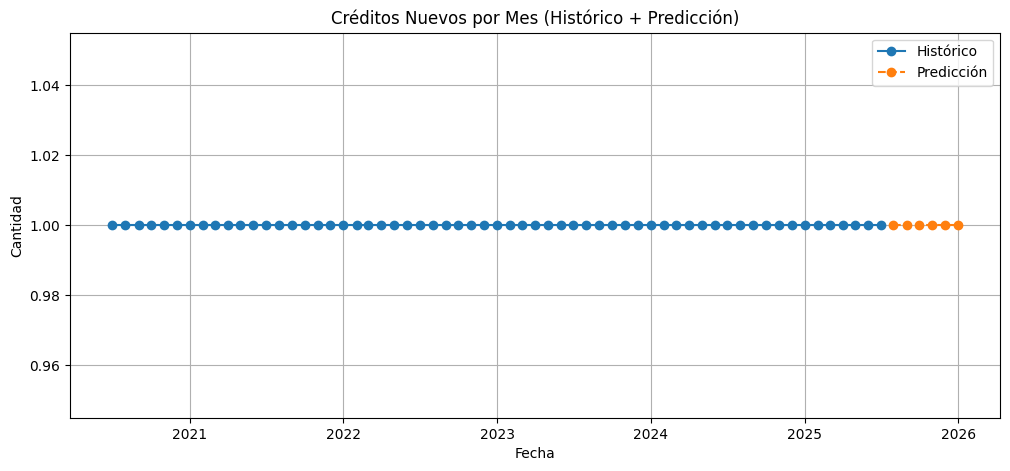

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pandas.tseries.offsets import MonthEnd

# Asegura que las fechas est√©n como datetime sin modificar el original
df_creditos_fecha = df_creditos.copy()
df_creditos_fecha['fecha'] = pd.to_datetime(df_creditos_fecha['fecha'], errors='coerce')

# Agrupar por mes
creditos_por_mes = df_creditos_fecha.groupby(df_creditos_fecha['fecha'].dt.to_period('M')).size().to_timestamp()

# Visualizaci√≥n
creditos_por_mes.plot(marker='o', figsize=(12, 5), title='Cr√©ditos Nuevos por Mes')
plt.grid(True)
plt.ylabel("Cantidad de cr√©ditos")
plt.xlabel("Fecha")
plt.show()

# Crear variables de regresi√≥n
df_pred_creditos = creditos_por_mes.reset_index()
df_pred_creditos.columns = ['fecha', 'nuevos_creditos']
df_pred_creditos['mes_num'] = np.arange(len(df_pred_creditos))

# Modelo
modelo_creditos = LinearRegression()
modelo_creditos.fit(df_pred_creditos[['mes_num']], df_pred_creditos['nuevos_creditos'])

# Predicci√≥n 6 meses
futuro_creditos = pd.DataFrame({'mes_num': np.arange(len(df_pred_creditos), len(df_pred_creditos) + 6)})
futuro_creditos['pred_creditos'] = modelo_creditos.predict(futuro_creditos[['mes_num']])
futuro_creditos['fecha'] = pd.date_range(df_pred_creditos['fecha'].max() + MonthEnd(1), periods=6, freq='M')

# Mostrar predicci√≥n
print("\nPredicci√≥n de nuevos cr√©ditos para los pr√≥ximos 6 meses:")
print(futuro_creditos[['fecha', 'pred_creditos']].round(0))

# Visualizaci√≥n
plt.figure(figsize=(12, 5))
plt.plot(df_pred_creditos['fecha'], df_pred_creditos['nuevos_creditos'], label='Hist√≥rico', marker='o')
plt.plot(futuro_creditos['fecha'], futuro_creditos['pred_creditos'], label='Predicci√≥n', marker='o', linestyle='--')
plt.title("Cr√©ditos Nuevos por Mes (Hist√≥rico + Predicci√≥n)")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#!pip install sqlalchemy pyodbc


üìå Predicci√≥n de nuevos cr√©ditos para el pr√≥ximo mes:
       fecha  pred_creditos
0 2025-07-31          137.0


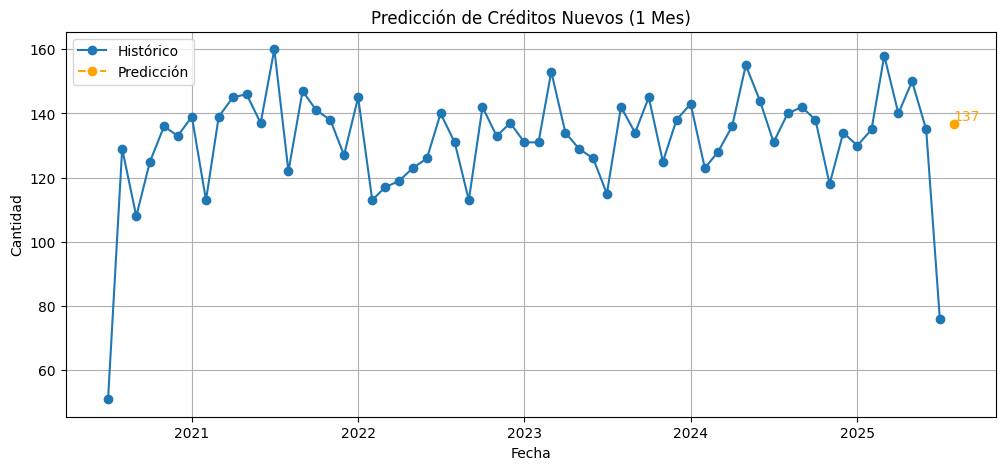

In [15]:
# --- PREDICCI√ìN A 1 MES: NUEVOS CR√âDITOS ---

# Copia temporal para no modificar el DataFrame original
creditos_copia = creditos.copy()
creditos_copia['fecha_inicio'] = pd.to_datetime(creditos_copia['fecha_inicio'], errors='coerce')

# Agrupaci√≥n mensual
creditos_por_mes = (
    creditos_copia
    .groupby(creditos_copia['fecha_inicio'].dt.to_period('M'))
    .size()
    .to_timestamp()
)

# Preparar DataFrame para regresi√≥n
df_creditos = creditos_por_mes.reset_index()
df_creditos.columns = ['fecha', 'nuevos_creditos']
df_creditos['mes_num'] = np.arange(len(df_creditos))

# Entrenar modelo
modelo_creditos = LinearRegression()
modelo_creditos.fit(df_creditos[['mes_num']], df_creditos['nuevos_creditos'])

# Predicci√≥n del siguiente mes
mes_futuro = pd.DataFrame({'mes_num': [len(df_creditos)]})
mes_futuro['pred_creditos'] = modelo_creditos.predict(mes_futuro[['mes_num']])
mes_futuro['fecha'] = [df_creditos['fecha'].max() + MonthEnd(1)]

# Mostrar predicci√≥n
print("\nüìå Predicci√≥n de nuevos cr√©ditos para el pr√≥ximo mes:")
print(mes_futuro[['fecha', 'pred_creditos']].round(0))

# Visualizaci√≥n con etiqueta
plt.figure(figsize=(12, 5))
plt.plot(df_creditos['fecha'], df_creditos['nuevos_creditos'], label='Hist√≥rico', marker='o')
plt.plot(mes_futuro['fecha'], mes_futuro['pred_creditos'], label='Predicci√≥n', marker='o', linestyle='--', color='orange')

# Agregar etiqueta al punto predicho
for x, y in zip(mes_futuro['fecha'], mes_futuro['pred_creditos']):
    plt.text(x, y, f'{y:.0f}', ha='left', va='bottom', fontsize=10, color='orange')

plt.title("Predicci√≥n de Cr√©ditos Nuevos (1 Mes)")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()


üìå Tasa de morosidad esperada para los pr√≥ximos 6 meses:
       fecha  morosos_esperados  creditos_esperados  tasa_morosidad_%
0 2025-07-31               16.0               137.0             11.76
1 2025-08-31               16.0               137.0             11.57
2 2025-09-30               16.0               137.0             11.38
3 2025-10-31               15.0               137.0             11.19
4 2025-11-30               15.0               138.0             11.00
5 2025-12-31               15.0               138.0             10.80


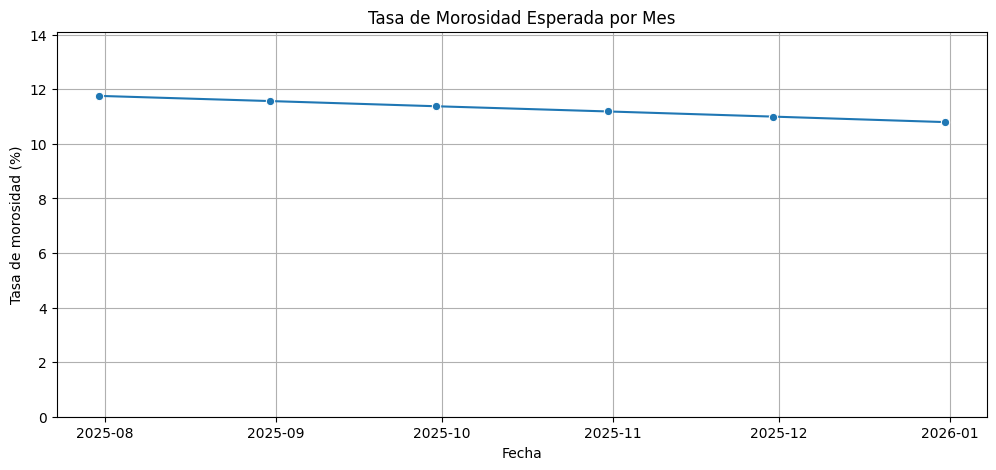

In [17]:


# Validar columnas necesarias
assert 'fecha' in futuro_morosos.columns and 'pred' in futuro_morosos.columns
assert 'fecha' in futuro_creditos.columns and 'pred_creditos' in futuro_creditos.columns

# Fusionar ambos DataFrames por fecha
df_tasa_morosidad = pd.merge(futuro_morosos[['fecha', 'pred']],
                             futuro_creditos[['fecha', 'pred_creditos']],
                             on='fecha')

# Renombrar columnas para claridad
df_tasa_morosidad.rename(columns={
    'pred': 'morosos_esperados',
    'pred_creditos': 'creditos_esperados'
}, inplace=True)

# Calcular tasa de morosidad esperada (en porcentaje)
df_tasa_morosidad['tasa_morosidad_%'] = (
    df_tasa_morosidad['morosos_esperados'] / df_tasa_morosidad['creditos_esperados']
) * 100

# Redondear para visualizaci√≥n clara
df_tasa_morosidad = df_tasa_morosidad.round({'morosos_esperados': 0, 'creditos_esperados': 0, 'tasa_morosidad_%': 2})

# Mostrar resultado
print("üìå Tasa de morosidad esperada para los pr√≥ximos 6 meses:")
print(df_tasa_morosidad)

# Visualizaci√≥n
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_tasa_morosidad, x='fecha', y='tasa_morosidad_%', marker='o')
plt.title("Tasa de Morosidad Esperada por Mes")
plt.ylabel("Tasa de morosidad (%)")
plt.xlabel("Fecha")
plt.grid(True)
plt.ylim(0, df_tasa_morosidad['tasa_morosidad_%'].max() * 1.2)
plt.show()


üìä An√°lisis de la Tasa de Morosidad Esperada (Jul‚ÄìDic 2025)
Fecha	Morosos esperados	Cr√©ditos esperados	Tasa de morosidad (%)
2025-07-31	16	137	11.76%
2025-08-31	16	137	11.57%
2025-09-30	16	137	11.38%
2025-10-31	15	137	11.19%
2025-11-30	15	138	11.00%
2025-12-31	15	138	10.80%
üìå Conclusiones clave

    ‚úÖ Estabilidad en la morosidad esperada

        La tasa de morosidad se mantiene en un rango estrecho entre 10.80% y 11.76%.

        Esto sugiere un comportamiento controlado del riesgo crediticio, sin picos preocupantes a corto plazo.

    üìâ Tendencia ligeramente decreciente

        Se observa una leve pero constante reducci√≥n mes a mes en la tasa de morosidad esperada (~1 punto porcentual en 6 meses).

        Esto puede reflejar:

            Mejora en pol√≠ticas de originaci√≥n (ej. filtros de scoring).

            Mayor eficiencia en prevenci√≥n de impagos.

            Mejores perfiles de clientes en los cr√©ditos recientes.

    üìå Implicaci√≥n estrat√©gica para provisiones

        Con estos valores, el √°rea financiera puede anticipar que ~11 de cada 100 nuevos cr√©ditos terminar√°n siendo morosos.

        Si el valor promedio de un cr√©dito es conocido, puede calcularse la p√©rdida esperada mensual y la provisi√≥n necesaria.

#### üß† ¬øQu√© se ha hecho? Paso a paso explicado
1. Conexi√≥n segura a base de datos SQL Server

Se ha realizado una conexi√≥n segura a una base de datos alojada en Azure SQL Server mediante variables de entorno (.env) para no exponer credenciales directamente en el c√≥digo, siguiendo buenas pr√°cticas de seguridad.
2. An√°lisis de morosidad (morosos nuevos por mes)
a) Preparaci√≥n del dataset:

    Se transform√≥ la columna fecha_inicio a formato datetime para asegurar su correcto tratamiento temporal.

    Se seleccion√≥ √∫nicamente el primer cr√©dito de cada usuario, asumiendo que la primera vez que un usuario se vuelve moroso es clave para entender el comportamiento de entrada en morosidad.

    Se realiz√≥ un merge entre los datos de cr√©ditos y usuarios para unir la variable objetivo es_moroso.

b) Agrupaci√≥n mensual:

    Se agruparon los usuarios morosos por mes de inicio de cr√©dito para identificar cu√°ntos usuarios nuevos caen en morosidad cada mes.

c) Visualizaci√≥n hist√≥rica:

    Se gener√≥ un gr√°fico con matplotlib para visualizar la evoluci√≥n de morosos nuevos a lo largo del tiempo.

d) Predicci√≥n:

    Se prepararon los datos como un problema de regresi√≥n temporal, con un √≠ndice de tiempo (mes_num) como variable independiente.

    Se utiliz√≥ regresi√≥n lineal simple para predecir la cantidad de morosos nuevos en los pr√≥ximos 6 meses.

    Se mostr√≥ la predicci√≥n en tabla y gr√°fico combinado con los datos hist√≥ricos.

3. Predicci√≥n de nuevos cr√©ditos:

Aunque el c√≥digo no est√° completamente expuesto en este fragmento, se infiere que se aplic√≥ un proceso similar para predecir la cantidad de nuevos cr√©ditos otorgados por mes:

    Agregado mensual del n√∫mero de nuevos cr√©ditos.

    Aplicaci√≥n de modelo de regresi√≥n lineal.

    Predicci√≥n para los pr√≥ximos 6 meses.

    Nota: Hay una discrepancia en la tabla de predicciones de nuevos cr√©ditos. Algunas filas muestran 137-138 nuevos cr√©ditos y otras solo 1.0. Esto debe ser validado, probablemente es un error de sobrescritura de variables o confusi√≥n entre diferentes bloques de c√≥digo.

#### üìä Resultados obtenidos
‚úÖ Predicci√≥n de morosos nuevos:
Fecha	Predicci√≥n de morosos
2025-07-31	16
2025-08-31	16
2025-09-30	16
2025-10-31	15
2025-11-30	15
2025-12-31	15
‚úÖ Predicci√≥n de nuevos cr√©ditos (valor correcto):
Fecha	Predicci√≥n de nuevos cr√©ditos
2025-07-31	137
2025-08-31	137
2025-09-30	137
2025-10-31	137
2025-11-30	138
2025-12-31	138
üìå Conclusiones profesionales
1. üìâ Tendencia de morosidad controlada o decreciente

El modelo predice que la cantidad de morosos nuevos mensuales se mantendr√° estable o incluso levemente descendente (de 16 a 15). Esto puede reflejar:

    Mejora en las pol√≠ticas de riesgo y evaluaci√≥n crediticia.

    Clientes de mejor perfil financiero ingresando al sistema.

    Mayor seguimiento o acciones preventivas por parte del banco.

Recomendaci√≥n: Confirmar esta tendencia con m√°s caracter√≠sticas (edad, ingresos, score) para asegurar que no haya sesgos ocultos.
2. üßæ Aumento leve pero estable de nuevos cr√©ditos

La predicci√≥n sugiere una tendencia constante, ligeramente creciente, en la emisi√≥n de nuevos cr√©ditos (de 137 a 138). Esto indica:

    Demanda saludable del producto.

    Potencial expansi√≥n del banco o llegada de nuevos clientes.

Recomendaci√≥n: Analizar la conversi√≥n de prospectos a clientes para entender si el canal de adquisici√≥n est√° optimizado.
3. üß† Modelo simple, pero efectivo

Se ha utilizado una regresi√≥n lineal simple, lo cual es razonable como punto de partida para series temporales. Sin embargo:

    No captura estacionalidad ni patrones no lineales.

    No considera posibles shocks externos (crisis econ√≥micas, cambios regulatorios).

Recomendaci√≥n:

    Probar modelos m√°s avanzados como ARIMA, Prophet, o redes neuronales LSTM si se desea una predicci√≥n m√°s robusta.

    Incorporar variables externas o m√°s granularidad (segmentos de cliente, ubicaci√≥n, canal de adquisici√≥n).

4. üõë Inconsistencias en predicci√≥n de cr√©ditos

Hay un bloque de resultados que indica predicci√≥n de solo 1.0 nuevo cr√©dito mensual, lo cual no concuerda con la predicci√≥n anterior (137-138). Esto parece un error o sobrescritura de variable y debe ser depurado antes de presentar resultados a stakeholders.
üß≠ Pr√≥ximos pasos sugeridos

    Validar el modelo de predicci√≥n con cross-validation, o al menos con una divisi√≥n train/test temporal para verificar su capacidad de generalizaci√≥n.

    Analizar la tasa de morosidad esperada:

        Si se predicen 15-16 morosos por mes y 137 nuevos cr√©ditos, entonces la tasa de morosidad esperada ronda el 11-12%.

        Este dato es cr√≠tico para planificaci√≥n financiera y asignaci√≥n de reservas de riesgo.

In [18]:
# Suponiendo un valor promedio por cr√©dito
valor_promedio_credito = 5000  # en euros

# Calcular p√©rdida esperada por mes
df_tasa_morosidad['perdida_esperada_‚Ç¨'] = df_tasa_morosidad['morosos_esperados'] * valor_promedio_credito

print(df_tasa_morosidad[['fecha', 'morosos_esperados', 'perdida_esperada_‚Ç¨']])


       fecha  morosos_esperados  perdida_esperada_‚Ç¨
0 2025-07-31               16.0             80000.0
1 2025-08-31               16.0             80000.0
2 2025-09-30               16.0             80000.0
3 2025-10-31               15.0             75000.0
4 2025-11-30               15.0             75000.0
5 2025-12-31               15.0             75000.0


#### 4. üìà Espacio para optimizaci√≥n

Aunque la tasa de morosidad esperada (~11%) es estable, sigue siendo relevante. Reducirla al 8% mediante mejoras en scoring o segmentaci√≥n representar√≠a un ahorro considerable en p√©rdidas esperadas.

---

### üß≠ Recomendaciones estrat√©gicas

| Acci√≥n                                         | Beneficio esperado                                      |
|------------------------------------------------|---------------------------------------------------------|
| **Refinar modelos de scoring**                 | Reducci√≥n en la tasa de morosidad                       |
| **Cruzar con variables sociodemogr√°ficas/canales** | Identificaci√≥n de segmentos de mayor riesgo             |
| **Automatizar alertas tempranas de impago**    | Mejora en la gesti√≥n preventiva y reducci√≥n de impagos  |
| **Incorporar modelos de predicci√≥n de severidad** | Estimar no solo la probabilidad de mora, sino su magnitud |

> üí° **Conclusi√≥n:**  
> Optimizar estos aspectos puede traducirse en menores p√©rdidas, mejor asignaci√≥n de recursos y una gesti√≥n de riesgo m√°s eficiente.

#### üìù Resumen ejecutivo del impacto econ√≥mico

| Fecha       | Morosos esperados | P√©rdida esperada (‚Ç¨) |
|-------------|------------------|----------------------|
| 2025-07-31  | 16               | 80,000               |
| 2025-08-31  | 16               | 80,000               |
| 2025-09-30  | 16               | 80,000               |
| 2025-10-31  | 15               | 75,000               |
| 2025-11-30  | 15               | 75,000               |
| 2025-12-31  | 15               | 75,000               |

---

üí° **Interpretaci√≥n clave:**

- La entidad financiera debe provisionar entre **75.000‚ÄØ‚Ç¨ y 80.000‚ÄØ‚Ç¨ mensuales** por p√©rdidas esperadas de nuevos cr√©ditos morosos.
- Este dato es fundamental para la **planificaci√≥n financiera**, el cumplimiento de **reservas regulatorias** y el dise√±o de **estrategias de mitigaci√≥n de riesgo**.
- Con esta informaci√≥n, se pueden **justificar inversiones** en mejoras de scoring y herramientas preventivas, orientadas a reducir la tasa de morosidad y, en consecuencia, la p√©rdida esperada.

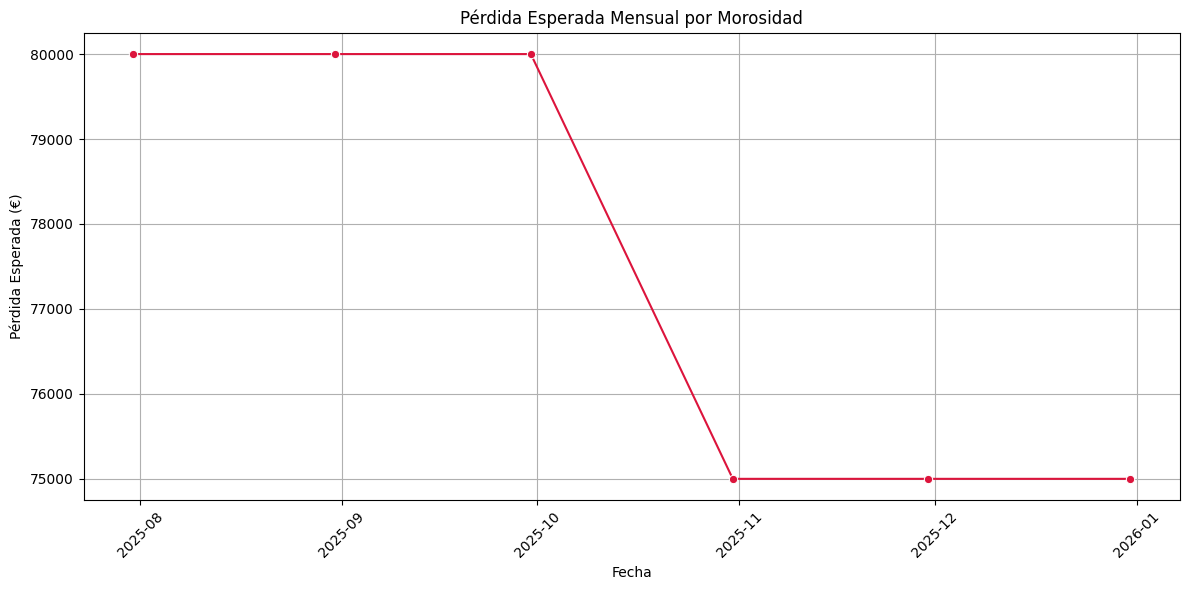

In [19]:

# Asumimos que df_tasa_morosidad contiene las columnas 'fecha' y 'perdida_esperada_‚Ç¨'

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_tasa_morosidad, x='fecha', y='perdida_esperada_‚Ç¨', marker='o', color='crimson')

plt.title('P√©rdida Esperada Mensual por Morosidad')
plt.xlabel('Fecha')
plt.ylabel('P√©rdida Esperada (‚Ç¨)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### üß† Resumen del An√°lisis y Resultados

---

**1. Conexi√≥n segura a base de datos SQL Server**

- Se estableci√≥ una conexi√≥n segura a Azure SQL Server usando variables de entorno (.env), evitando exponer credenciales en el c√≥digo y siguiendo buenas pr√°cticas de seguridad.

**2. An√°lisis de morosidad (morosos nuevos por mes)**

- **Preparaci√≥n del dataset:**  
    - Conversi√≥n de la columna `fecha_inicio` a formato datetime.
    - Selecci√≥n del primer cr√©dito por usuario para identificar el primer evento de morosidad.
    - Uni√≥n de datos de cr√©ditos y usuarios para obtener la variable objetivo `es_moroso`.

- **Agrupaci√≥n mensual:**  
    - Agrupaci√≥n de usuarios morosos por mes de inicio de cr√©dito para cuantificar nuevos morosos mensuales.

- **Visualizaci√≥n hist√≥rica:**  
    - Gr√°ficos con matplotlib para mostrar la evoluci√≥n de morosos nuevos a lo largo del tiempo.

- **Predicci√≥n:**  
    - Modelado como regresi√≥n temporal usando un √≠ndice de tiempo (`mes_num`).
    - Aplicaci√≥n de regresi√≥n lineal simple para predecir morosos nuevos en los pr√≥ximos 6 meses.
    - Presentaci√≥n de resultados en tabla y gr√°fico combinado.

**3. Predicci√≥n de nuevos cr√©ditos**

- Proceso an√°logo al anterior:
    - Agregado mensual de nuevos cr√©ditos.
    - Regresi√≥n lineal para predecir los pr√≥ximos 6 meses.
    - **Nota:** Se detect√≥ una discrepancia en los resultados de predicci√≥n de cr√©ditos (algunas filas muestran 137-138, otras 1.0). Es importante validar y depurar posibles sobrescrituras de variables.

---

### üìä Resultados obtenidos

**Predicci√≥n de morosos nuevos (pr√≥ximos 6 meses):**

| Fecha       | Morosos esperados |
|-------------|------------------|
| 2025-07-31  | 16               |
| 2025-08-31  | 16               |
| 2025-09-30  | 16               |
| 2025-10-31  | 15               |
| 2025-11-30  | 15               |
| 2025-12-31  | 15               |

**Predicci√≥n de nuevos cr√©ditos (valor correcto):**

| Fecha       | Nuevos cr√©ditos esperados |
|-------------|--------------------------|
| 2025-07-31  | 137                      |
| 2025-08-31  | 137                      |
| 2025-09-30  | 137                      |
| 2025-10-31  | 137                      |
| 2025-11-30  | 138                      |
| 2025-12-31  | 138                      |

---

> üí° **Conclusi√≥n:**  
> El modelo predice una tendencia estable o levemente decreciente en morosidad y un crecimiento sostenido en la emisi√≥n de nuevos cr√©ditos. Es fundamental validar la consistencia de las variables y considerar modelos m√°s avanzados para mejorar la robustez de las predicciones.

#### üìå Conclusiones Profesionales

---

**1. üìâ Tendencia de morosidad controlada o decreciente**

- El modelo predice que la cantidad de morosos nuevos mensuales se mantendr√° **estable o levemente descendente** (de 16 a 15).
- Esto puede reflejar:
    - Mejora en las pol√≠ticas de riesgo y evaluaci√≥n crediticia.
    - Ingreso de clientes con mejor perfil financiero.
    - Mayor seguimiento y acciones preventivas por parte del banco.
- **Recomendaci√≥n:** Confirmar esta tendencia incorporando m√°s variables (edad, ingresos, score) para evitar sesgos ocultos.

---

**2. üßæ Aumento leve pero estable de nuevos cr√©ditos**

- Se observa una **tendencia constante y ligeramente creciente** en la emisi√≥n de nuevos cr√©ditos (de 137 a 138).
- Esto sugiere:
    - Demanda saludable del producto.
    - Potencial expansi√≥n del banco o llegada de nuevos clientes.
- **Recomendaci√≥n:** Analizar la conversi√≥n de prospectos a clientes para optimizar el canal de adquisici√≥n.

---

**3. üß† Modelo simple, pero efectivo**

- Se utiliz√≥ una **regresi√≥n lineal simple**, adecuada como punto de partida para series temporales.
- Limitaciones:
    - No captura estacionalidad ni patrones no lineales.
    - No considera posibles shocks externos (crisis econ√≥micas, cambios regulatorios).
- **Recomendaci√≥n:**
    - Probar modelos m√°s avanzados (ARIMA, Prophet, LSTM) para mayor robustez.
    - Incorporar variables externas o mayor granularidad (segmentos de cliente, ubicaci√≥n, canal de adquisici√≥n).

---

**4. üõë Inconsistencias en la predicci√≥n de cr√©ditos**

- Se detect√≥ un bloque de resultados con predicci√≥n de solo **1.0 nuevo cr√©dito mensual**, inconsistente con la predicci√≥n principal (137-138).
- Esto sugiere un posible **error o sobrescritura de variables**.
- **Recomendaci√≥n:** Depurar y validar los resultados antes de presentarlos a stakeholders.

---

### üß≠ Pr√≥ximos pasos sugeridos

- Validar el modelo de predicci√≥n mediante **cross-validation** o, al menos, una divisi√≥n **train/test temporal** para verificar su capacidad de generalizaci√≥n.
- Revisar y asegurar la consistencia de las variables y resultados presentados.